In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.nn import functional as F

import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import math

from minisom import MiniSom

False

In [13]:
X=[]
y=[]

for data in datasets.FashionMNIST('./data', transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]), download=True):
    X.append(data[0])
    y.append(data[1])

In [28]:
class TiedAutoencoder(nn.Module):
    def __init__(self, input_dim, encoding_dim, tied=False):
        super(TiedAutoencoder, self).__init__()

        hid_dim = int(math.sqrt(input_dim) * (math.sqrt(input_dim) / 3))

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hid_dim),
            nn.Dropout(0.05),
            nn.ReLU(),

            nn.Linear(hid_dim, encoding_dim),
            nn.Dropout(0.05),
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, hid_dim),
            nn.Dropout(0.05),
            nn.ReLU(),

            nn.Linear(hid_dim, input_dim),
            nn.Dropout(0.05),
            nn.Sigmoid(),
        )

        # Tying encoder and decoder weights
        if tied:
            self.decoder[0].weight.data = self.encoder[3].weight.data.t()
            self.decoder[3].weight.data = self.encoder[0].weight.data.t()

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        loss = F.mse_loss(decoded, x)
        return encoded, decoded, loss


In [29]:
encoding_dim = 64
learning_rate = 1e-4
epochs = 50
X_train, X_test, _, _ = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
input_dim = np.prod(np.shape(X_train[0]))

In [30]:
train_loader = DataLoader(X_train, batch_size=128, shuffle=True)

autoencoder_tied = TiedAutoencoder(input_dim, encoding_dim, tied=True)
optimizer_tied = optim.Adam(autoencoder_tied.parameters(), lr=learning_rate)
som_tied = MiniSom(16, 16, encoding_dim, sigma=3, learning_rate=learning_rate)

autoencoder = TiedAutoencoder(input_dim, encoding_dim, tied=False)
optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)
som = MiniSom(16, 16, encoding_dim, sigma=3, learning_rate=learning_rate) 

In [31]:
for epoch in range(epochs):
    for data in train_loader:
        inputs = data.view(data.size(0), -1)

        optimizer_tied.zero_grad(set_to_none=True)
        _, _, loss_t = autoencoder_tied(inputs)
        loss_t.backward()
        optimizer_tied.step()
        encoded_t, _, _ = autoencoder_tied(inputs)
        som_tied.train(encoded_t.detach().numpy(), 1)


        optimizer.zero_grad()
        _, _, loss = autoencoder(inputs)
        loss.backward()
        optimizer.step()
        encoded, _, _ = autoencoder(inputs)
        som.train(encoded.detach().numpy(), 1)
        
    print(f'\rEpoch [{epoch+1}/{epochs}] Loss: {loss_t.item():.4f}, {loss.item():.4f}', end='\n' if epoch%10 == 0 else '                                         ')

print("Training complete.")


Epoch [1/50] Loss: 0.6785, 0.6839
Epoch [11/50] Loss: 0.6492, 0.6473                                         
Epoch [16/50] Loss: 0.6403, 0.6396                                         

KeyboardInterrupt: 

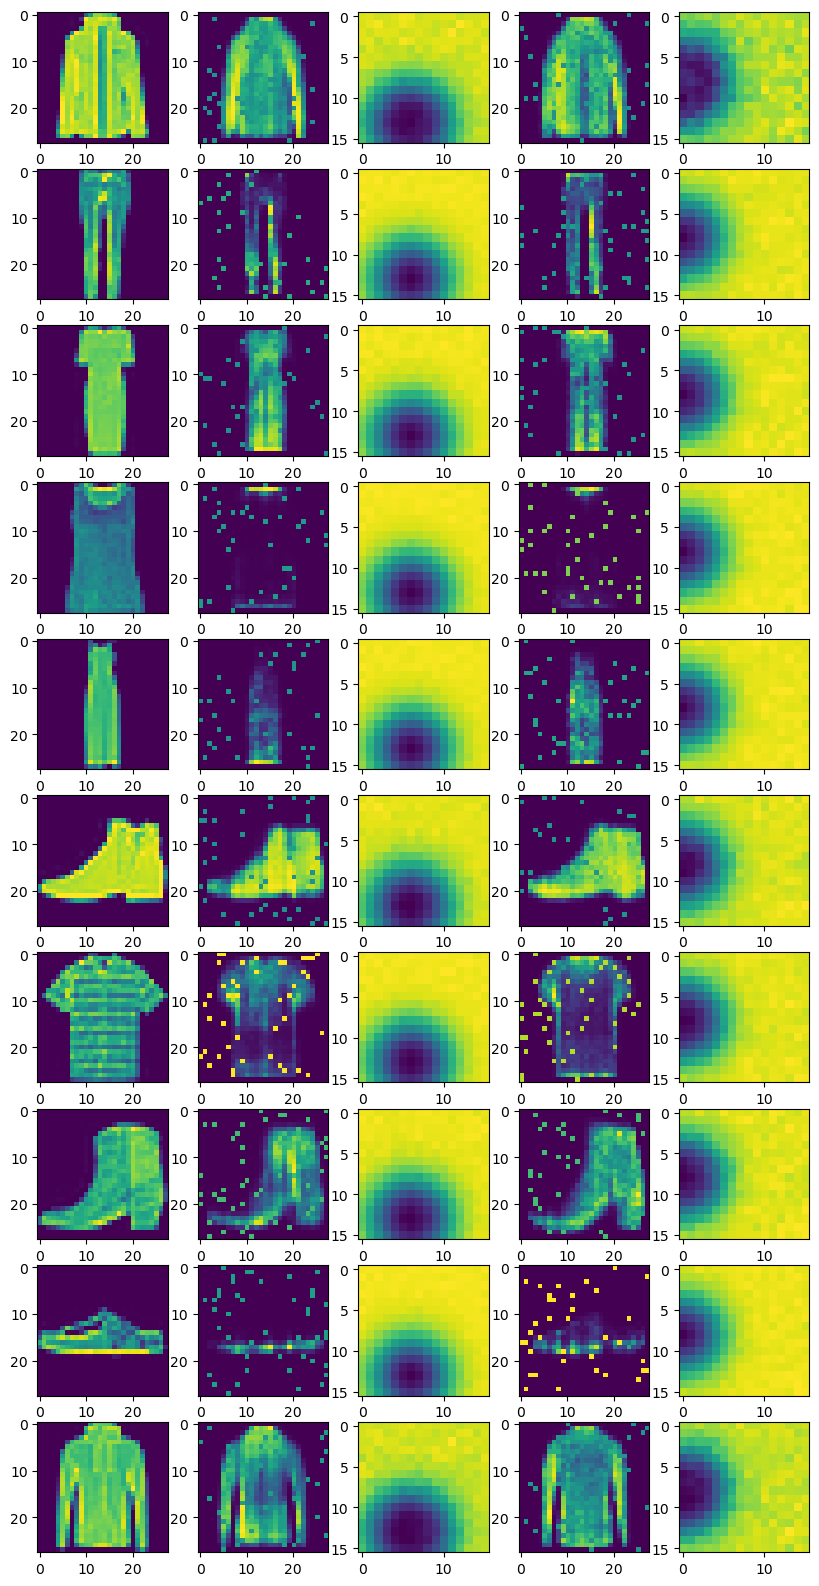

In [32]:
fig, axarr = plt.subplots(10, 5, figsize=(10, 20))
idxs = np.random.choice(len(X_test), 10)

for i, idx in enumerate(idxs):
    axarr[i, 0].imshow(X_test[idx].squeeze())

    encoded_t, decoded_t, _ = autoencoder_tied(torch.flatten(X_test[idx]))
    axarr[i, 1].imshow(np.reshape(decoded_t.detach().numpy(), (28, 28)))
    axarr[i, 2].imshow(som_tied.activate(encoded_t.detach().numpy()))

    encoded, decoded, _ = autoencoder(torch.flatten(X_test[idx]))
    axarr[i, 3].imshow(np.reshape(decoded.detach().numpy(), (28, 28)))
    axarr[i, 4].imshow(som.activate(encoded.detach().numpy()))
